#### This project is an introduction to NLP. The goal of the project is to build a model to classify tweets that are about a real disaster. This data comes from a Kaggle competition https://www.kaggle.com/c/nlp-getting-started/overview. 

##### Dataset: The dataset contains a training file that contains tex from tweets with labels and a test file for which we need to predict wether it was a disaster or not. The column descriptions are: 
**ID:**  
**Text: The text of the tweet**   
**Location: The location from where the tweet was sent**  
**Keyword: a particular keyword from the tweet (may be blank)**  
**Target: Label**       0)



#### Import standard Libraries to get started

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#### Import NLP Libraries

In [117]:
import nltk
import sklearn
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

#### Import Keras Libraries

In [190]:
import keras

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D,Flatten, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

#### Importing the training and test files

In [15]:
train_df = pd.read_csv("ML2 Projects/Disaster_Tweets/train.csv")
test_df = pd.read_csv("ML2 Projects/Disaster_Tweets/test.csv")
sample_df = pd.read_csv("ML2 Projects/Disaster_Tweets/sample_submission.csv")

#### Lets do a quick EDA

In [18]:
print(train_df.shape)
print(test_df.shape)
print(sample_df.shape)


(7613, 5)
(3263, 4)
(3263, 2)


### Lets do a detailed analysis of the training data to see what we are dealing with

In [20]:
print(train_df.info())
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Looks like missing entries for Keyword and Location...Lets see how many missing entries are there? 

In [31]:
train_df.isna().sum()


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

#### Lets see if the test set also has a similar distribution of missing values...If yes, we cannot delete these rows.

In [32]:
test_df.isna().sum()


id             0
keyword       26
location    1105
text           0
dtype: int64

#### Looks like we need to keep the missing values since the test set also has a similar distribution
#### Lets see the Top 20 keywords/loactions for disaster tweets. As wew can see, some of the most common words are: Buildings on Fire, evacuation, bridge collapse, wildfire etc.

<Axes: ylabel='keyword'>

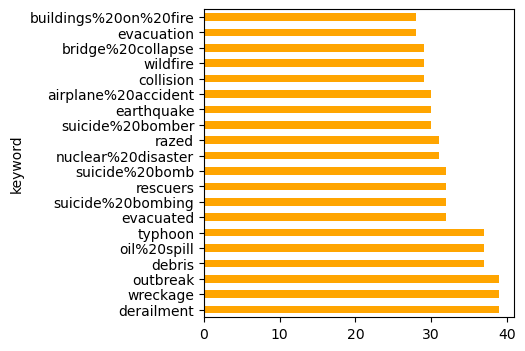

In [60]:
plt.figure(figsize=(4, 4))

top20_keywords = train_df.keyword[train_df.target==1].value_counts().head(20)
#top10_keywords.values
top20_keywords.plot(kind='barh',color='orange')

#### Lets check top 20 for non disaster tweets

<Axes: ylabel='keyword'>

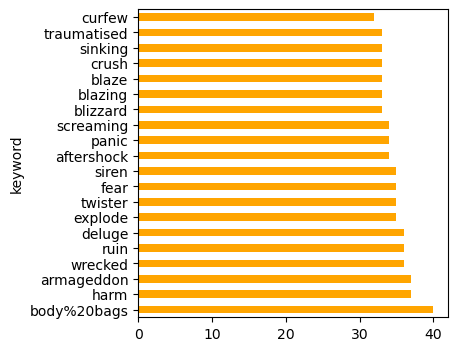

In [61]:
plt.figure(figsize=(4, 4))

top20_keywords_n = train_df.keyword[train_df.target==0].value_counts().head(20)
#top10_keywords.values
top20_keywords_n.plot(kind='barh',color='orange')

#### Surprisingly no common keywords other than wreckage in disaster tweets and wrecked in non disaster tweet. 

#### Lets check the most common locations for disaster and normal tweets

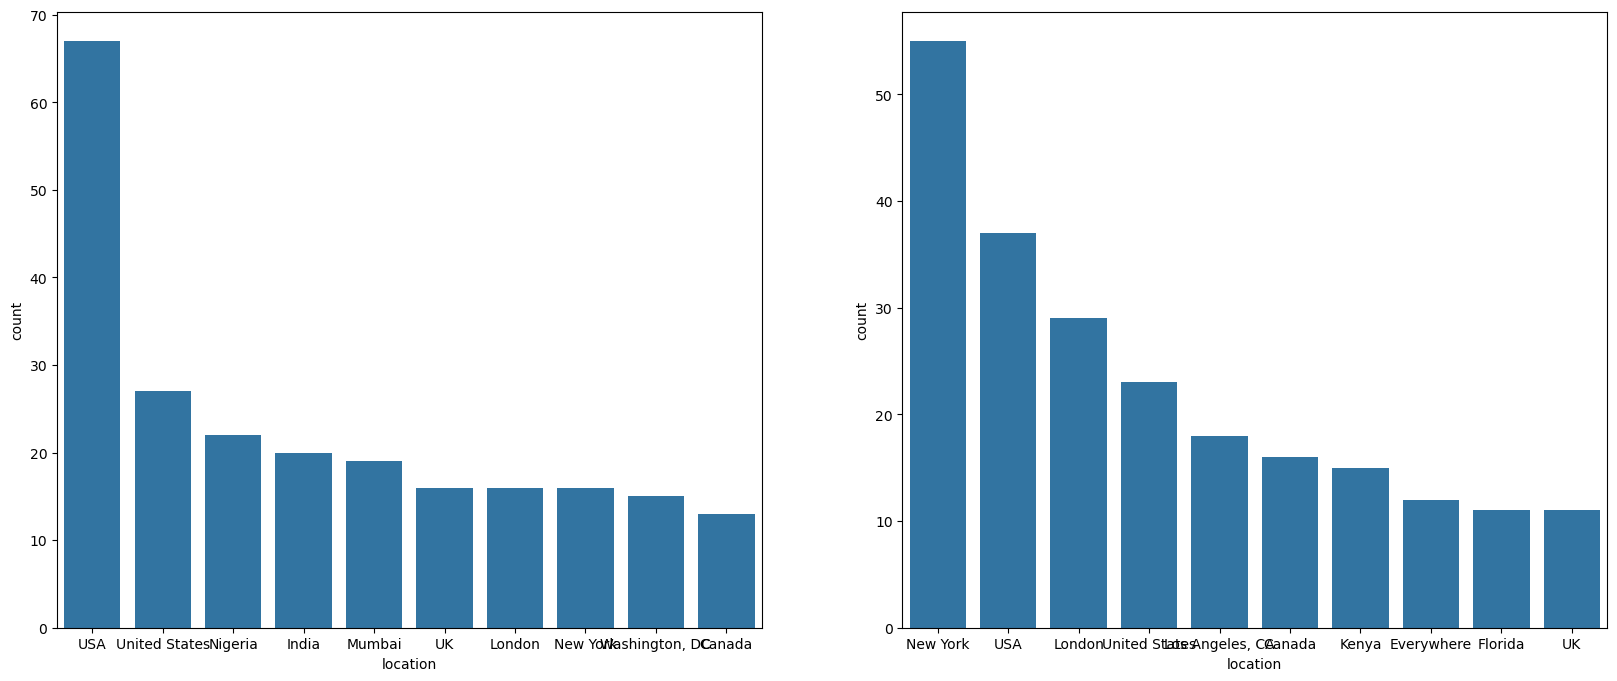

In [64]:
top10_locations = train_df.location[train_df.target==1].value_counts().head(10)
top10_locations_n = train_df.location[train_df.target==0].value_counts().head(10)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
sns.barplot(top10_locations, ax=ax1)
sns.barplot(top10_locations_n, ax=ax2)
plt.show()


#### Looks like USA and United States are entered as seperate locations. Also some tweets have cities and some have just the country.

#### Add tweet length and see if there is correlation...Not much difference both are around 15 words.

In [66]:
train_df['tweet_length'] = train_df['text'].apply(lambda x: len(str(x).split()))


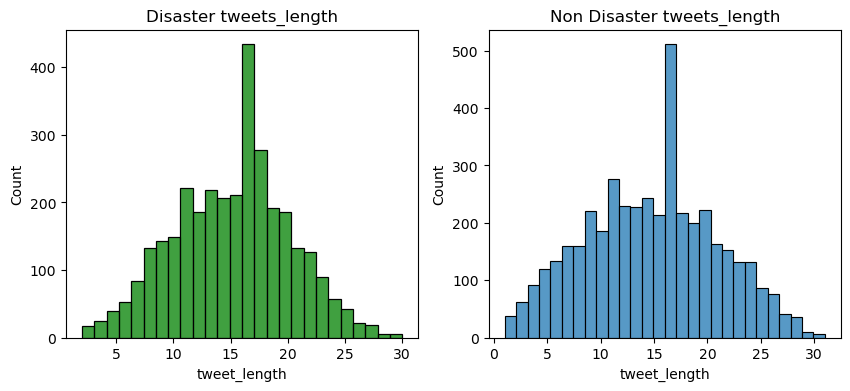

In [88]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
sns.histplot(train_df.tweet_length[train_df.target==1], ax=ax1,color='green').set(title = "Disaster tweets_length")
sns.histplot(train_df.tweet_length[train_df.target==0], ax=ax2).set(title = "Non Disaster tweets_length")
plt.show()


In [89]:
print(train_df.groupby('target')['tweet_length'].mean())


target
0    14.704744
1    15.167533
Name: tweet_length, dtype: float64


### Pre processing data

#### Lets look at the most freq words overall in the tweets....It is all stop words

In [93]:
freq_words = train_df['text'].str.split(expand=True).unstack().value_counts()
freq_words.head()

the    2575
a      1845
to     1805
in     1757
of     1722
Name: count, dtype: int64

<BarContainer object of 20 artists>

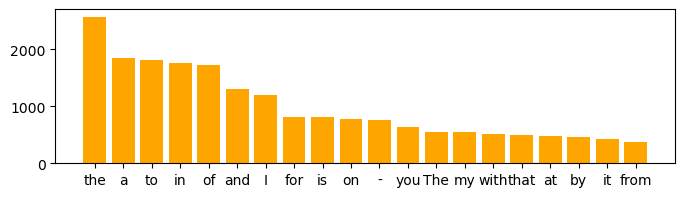

In [104]:
plt.figure(figsize=(8, 2))
#freq_words.head(10).plot(kind='barh',color = 'orange')
top20 = freq_words.head(20)
plt.bar(top20.index,top20.values,color='orange')

#### Convert everything to lower text

In [111]:
train_df['text'] = train_df['text'].str.lower()

#### Lets remove stopwords

In [112]:
from nltk.corpus import stopwords
#nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

train_df['text'] = train_df['text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))

train_df.head(3)

,id,keyword,location,text,target,tweet_length
0,1,NaN,NaN,deeds reason #earthquake may allah forgive us,1,13
1,4,NaN,NaN,forest fire near la ronge sask. canada,1,7
2,5,NaN,NaN,residents asked 'shelter place' notified offic...,1,22


#### Remove punctuations, digits and spaces

In [113]:
import re

In [114]:
train_df['text'] = train_df['text'].apply(lambda doc: re.sub(' +', ' ', doc))
train_df['text'] = train_df['text'].replace(r'\d+', '', regex=True)
train_df['text'] = train_df['text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))

#### Lets again check the freq words list...much cleaner now

In [115]:
freq_words = train_df['text'].str.split(expand=True).unstack().value_counts()
freq_words.head(10)

like      345
amp       300
im        299
fire      250
get       229
new       224
via       220
news      197
people    196
one       192
Name: count, dtype: int64

#### Lets tokenize the words useing Keras Tokenizer. This will breakdown the sentence into words. It will then assign numbers to each word and convert the text into a series of numbers that will form the input for our RNN Model.

These are some helpful links on this: https://medium.com/analytics-vidhya/understanding-nlp-keras-tokenizer-class-arguments-with-example-551c100f0cbd
https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html

In [127]:
words =10000
tokenizer = Tokenizer(num_words=words, split=' ')
tokenizer.fit_on_texts(train_df['text'].values)
X = tokenizer.texts_to_sequences(train_df['text'].values)
maxlen = max([len(x) for x in X])

#### Add padding so all sequences are of equal length (ex: add 6 0's as padding if max length =20 and the text length is 14)

In [128]:
X = pad_sequences(X,padding='post', truncating='post', maxlen=maxlen)
X[0]

array([4370,  730,  150,   53, 1457, 4371,   11,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

#### Split the data into training and test batches

In [154]:
x_train, x_test,y_train,y_test = train_test_split(X,train_df['target'], test_size = 0.2, random_state = 41)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(6090, 21)
(6090,)
(1523, 21)
(1523,)


#### Building the Rnn Model
#### Architecture: 
1. LTSM Layer with 64 RNNs
2. Dropout Layer to prevent overfitting
3. Dense layer with 64 neurons
4. Dense Layer with 32 neurons
5. Output Layer (1 with sigmoid activation since we have a binary classification)

In [164]:
# Adding EarlyStopping callback based on ROC AUC
early_stopping = EarlyStopping(monitor='val_accuracy', patience=50, mode='max', restore_best_weights=True)

# build model
model = Sequential()
model.add(Embedding(10000, 128, input_length=x_train.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))


In [165]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [166]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model1 = model.fit(x_train, y_train, epochs = 100, batch_size=256, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.5405 - loss: 0.6870 - val_accuracy: 0.5693 - val_loss: 0.6666
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6847 - loss: 0.5884 - val_accuracy: 0.7945 - val_loss: 0.4733
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8721 - loss: 0.3493 - val_accuracy: 0.7965 - val_loss: 0.4554
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.9089 - loss: 0.2515 - val_accuracy: 0.8004 - val_loss: 0.4941
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9253 - loss: 0.2141 - val_accuracy: 0.7728 - val_loss: 0.6092
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9435 - loss: 0.1646 - val_accuracy: 0.7840 - val_loss: 0.6013
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.9596 - loss: 0.1346 - val_accuracy: 0.7603 - val_loss: 0.6429
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9627 - loss: 0.1237 - val_accu

#### Lets quickly review the stats...Lets plot accuracy....Seems like the model is overfitting. Training Accuracy = 97% but validation accuracy is only 76%.

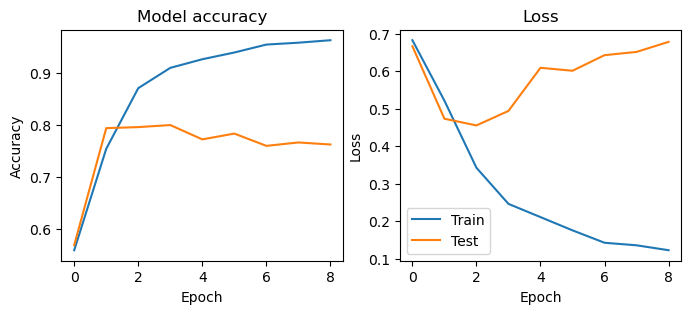

In [180]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))


ax1.plot(model1.history['accuracy'])
ax1.plot(model1.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(model1.history['loss'])
ax2.plot(model1.history['val_loss'])
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='best')



#### Make predictions and get F1 score

In [188]:
# Predict on validation data
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape)

# Calculate F1-score
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(1523, 1)
F1 Score: 0.7449664429530201


#### Lets now try a GRU model and see how it does compared to LTSM

In [191]:
model_gru = Sequential()
model_gru.add(Embedding(10000, 128, input_length=x_train.shape[1]))
model_gru.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model_gru.add(Dense(64, activation = 'relu'))
model_gru.add(Dense(32, activation = 'relu'))
model_gru.add(Dense(1, activation='sigmoid'))

model_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model_gru.fit(x_train, y_train, epochs = 100, batch_size=256, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - accuracy: 0.5479 - loss: 0.6866 - val_accuracy: 0.5693 - val_loss: 0.6833
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.5829 - loss: 0.6719 - val_accuracy: 0.7787 - val_loss: 0.6109
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8368 - loss: 0.4099 - val_accuracy: 0.7702 - val_loss: 0.5830
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.8983 - loss: 0.2870 - val_accuracy: 0.8070 - val_loss: 0.5322
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9283 - loss: 0.2071 - val_accuracy: 0.7991 - val_loss: 0.5322
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.9421 - loss: 0.1655 - val_accuracy: 0.7833 - val_loss: 0.5440
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9539 - loss: 0.1353 - val_accuracy: 0.7754 - val_loss: 0.5367
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9619 - loss: 0.1073 - val_accurac

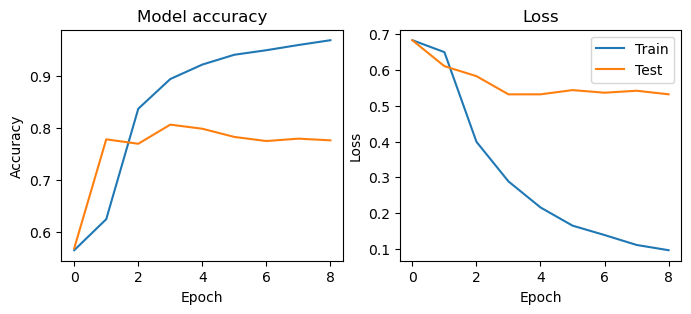

In [195]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))


ax1.plot(history2.history['accuracy'])
ax1.plot(history2.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')

ax2.plot(history2.history['loss'])
ax2.plot(history2.history['val_loss'])
ax2.set_title('Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='best')



#### Check F1 score

In [215]:
# Predict on validation data
y_pred = model_gru.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
print(y_pred.shape)

# Calculate F1-score
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
(1523, 1)
F1 Score: 0.7562189054726368


#### Pretty Similar performance from both the models but F1 score is slightly better at 75.6%

#### Lets change the architecture and see if we get better results

#### Architecture
I have added 2 dense layers, 1 with the same dimension as the output from LSTM Layer and 1 with 64 dimensions.
Changed the optimizer to RMS Prop, epochs to 10  and removed early stopping

In [205]:
model3 = Sequential()
model3.add(Embedding(10000, 128, input_length=x_train.shape[1]))
model3.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model3.add(Dense(128, activation = 'relu'))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(x_train, y_train, epochs = 10, batch_size=256, validation_data=(x_test, y_test))


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 164ms/step - accuracy: 0.5650 - loss: 0.6863 - val_accuracy: 0.5693 - val_loss: 0.6820
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5786 - loss: 0.6795 - val_accuracy: 0.5634 - val_loss: 0.6838
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.5817 - loss: 0.6715 - val_accuracy: 0.6664 - val_loss: 0.6293
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7343 - loss: 0.5491 - val_accuracy: 0.7859 - val_loss: 0.4773
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.8408 - loss: 0.4040 - val_accuracy: 0.8004 - val_loss: 0.4652
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.8686 - loss: 0.3530 - val_accuracy: 0.7853 - val_loss: 0.4780
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.8688 - loss: 0.3412 - val_accuracy: 0.7945 - val_loss: 0.5078
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.8984 - loss: 0.2878 - val_accuracy: 0.80

#### lets check the F1 score

In [208]:
# Predict on validation data
y_pred = model3.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")



48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
F1 Score: 0.7283142389525368


#### Not much different...lets go with the GRU model since it had the best F1 score and make submissions to Kaggle

#### lets process the test file to get it ready for predictions

In [219]:
test_df['text'] = test_df['text'].str.lower()
test_df['text'] = test_df['text'].apply(lambda doc: ' '.join([word for word in doc.split() if word not in (stop_words)]))
test_df['text'] = test_df['text'].apply(lambda doc: re.sub(' +', ' ', doc))
test_df['text'] = test_df['text'].replace(r'\d+', '', regex=True)
test_df['text'] = test_df['text'].apply(lambda doc: re.sub(r'[^\w\s]+', '', doc))

In [220]:
x_submission = tokenizer.texts_to_sequences(test_df['text'].values)
x_submission = pad_sequences(x_submission,padding='post', truncating='post', maxlen=maxlen)


In [221]:
x_submission.shape

(3263, 21)

#### Add predictions to the test file to submit to kaggle

In [223]:
yhat = model_gru.predict(x_submission)
yhat = (yhat > 0.5).astype(int)
test_df['target'] = yhat
disaster = test_df[['id', 'target']]
disaster.to_csv('disaster.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


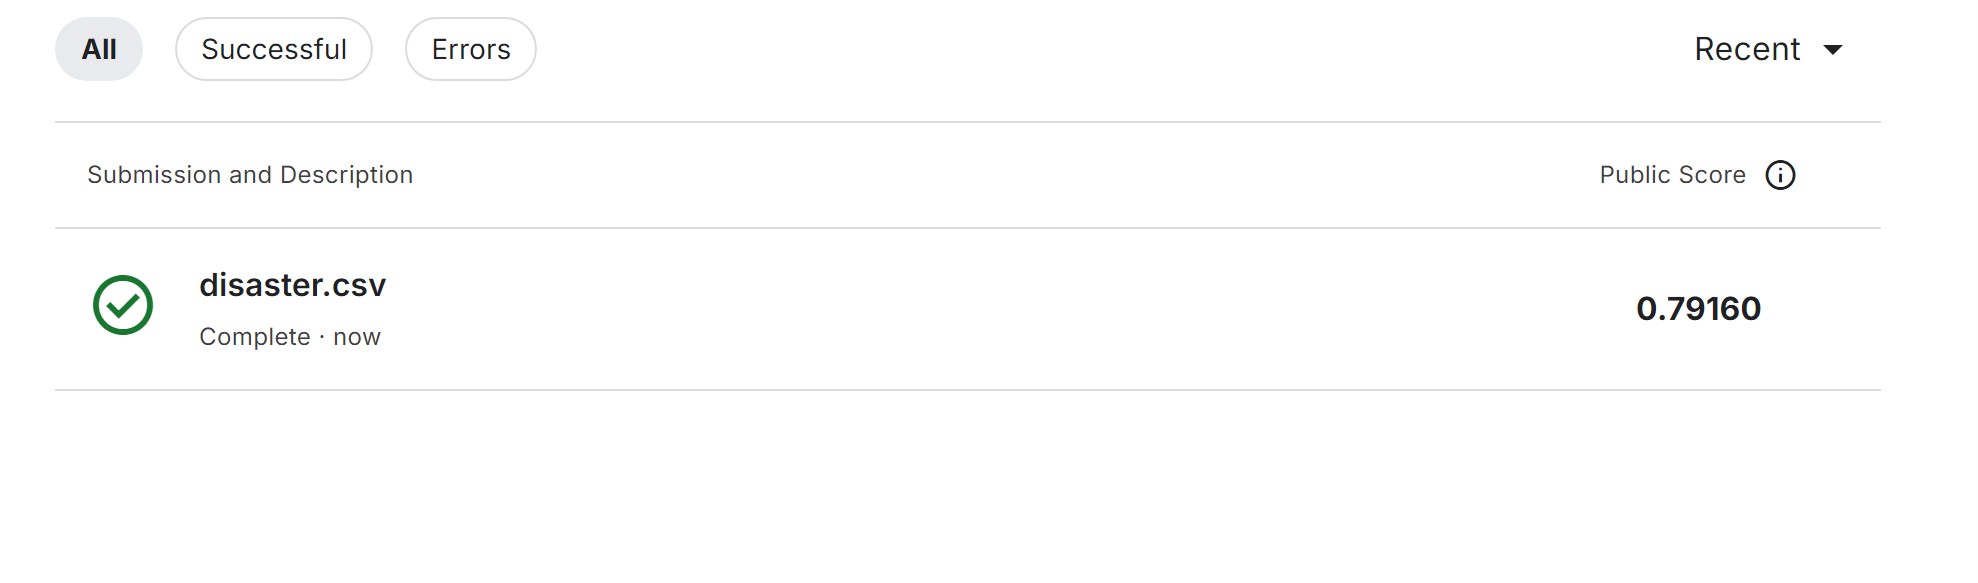

### Project Summary
#### For this project we had to make predictions on wether the tweet was for a real disaster or not. For this we used keras to tokenize the text and translate it into a sequence of numbers. We then used the sequence as an input to a neural network to make predictions on test data.

#### We experimented with 2 types of RNN models: LSTM and GRU. We also tried adam and rms prop as optimizers. GRU model gave us the best validation F1 score of 75.6%. That is the model I used to make submissions to Kaggle. 

#### Key Takeaways: Need to experimnet more with the architecture and hyper parameters to get the score to 85%+. If anyone was able to use similar startegy but were able to get 85%+ score, please share what worked best.